In [1]:
#ds=xr.Dataset({'zKuObs':zKuObs_Strat_xr,'zKaObs':zKaObs_Strat_xr,'binZeroDeg':binZeroDeg_Strat_xr,'pia_HB_DPR':pia_HB_DPR_strat_xr,'pia_HB_CMB':pia_HB_CMB_strat_xr,'binClutterFree':binClutterFree_Strat_xr,'binRealSurface':binRealSurface_Strat_xr,'jRay':jRay_Strat_xr,'logdNw':logdNw_Strat_xr,'binStormTop':binStormTop_Strat_xr,'nearSurfPrecipTotRate':nearSurfPrecipTotRate_Strat_xr})

import numpy as np
import netCDF4 as nc
with nc.Dataset('data/convective_training_data.nc','r') as ncf:
    zKuObs = ncf['zKuObs'][:]
    zKaObs = ncf['zKaObs'][:]
    binZeroDeg = ncf['binZeroDeg'][:]
    pia_HB_DPR = ncf['pia_HB_DPR'][:]
    pia_HB_CMB = ncf['pia_HB_CMB'][:]
    binClutterFree = ncf['binClutterFree'][:]
    binRealSurface = ncf['binRealSurface'][:]
    jRay = ncf['jRay'][:]
    logdNw= ncf['logdNw'][:]
    binStormTop= ncf['binStormTop'][:]
    nearSurfPrecipTotRate = ncf['nearSurfPrecipTotRate'][:]
n_bins_L=[]


In [16]:

dn_mean=np.log10(0.08e8)
print(dn_mean)


6.903089986991944


In [40]:
dbinL=[]
zmL=[]
log10dNL=[]
icount=0
nSeqL=[]
xL=[]
yL=[]
for i in range(zKaObs.shape[0]):
    n_bins_prof=binClutterFree[i]-binStormTop[i]
    n_bins_L.append(n_bins_prof)
    top=binStormTop[i]
    bot=binClutterFree[i]
    top2=binStormTop[i]//2
    bot2=binClutterFree[i]//2
    zm1=np.log10((10**(0.1*zKuObs[i,2*top2:2*bot2][::2])+10**(0.1*zKuObs[i,2*top2:2*bot2+1][1::2])+1e-3)/2)*10
    zm1[zm1<0]=0
    zmL.extend(zm1)
    log10dN_cmb=logdNw[i,top2:bot2]
    log10dN_cmb[log10dN_cmb<3]=6.9
    log10dNL.extend(log10dN_cmb-6.9)
    dbin=(np.arange(top2,bot2)-binZeroDeg[i])
    xL.append([(zm1-27)/8.,dbin/23.0])
    yL.append([log10dN_cmb-6.9,pia_HB_CMB[i,0]])  
    nSeqL.append((bot2-top2))
    if bot2-top2>80:
        print(bot2,top2)
        stop
    dbinL.extend(dbin/23)
    if zm1.shape[0]==log10dN_cmb.shape[0]:
        icount+=1
print(icount)

77324


In [72]:
n_seq_max=(np.max(nSeqL))
x_input_paddedL=[]
y_output_paddedL=[]
y_output_scalarL=[]
n_seq_inputL=[]
for i,nseq in enumerate(nSeqL):
    if nseq<1:
        continue
    x1=np.zeros((n_seq_max,2))
    x1[:nseq,0]=xL[i][0]
    x1[:nseq,1]=xL[i][1]
    x_input_paddedL.append(x1)
    y1=np.zeros((n_seq_max,1))
    y1[:nseq,0]=yL[i][0]
    y_output_paddedL.append(y1)
    y_output_scalarL.append(np.log10(1+yL[i][1])*3)
    n_seq_inputL.append(nseq)

In [73]:
y_output_scalarL=np.array(y_output_scalarL)
print(y_output_scalarL.mean(),y_output_scalarL.std())

0.24349402008667048 0.2826326465218051


In [42]:
x_input_paddedL=np.array(x_input_paddedL)
y_output_paddedL=np.array(y_output_paddedL)
y_output_scalarL=np.array(y_output_scalarL)[:,np.newaxis]
print(x_input_paddedL.shape)
print(y_output_paddedL.shape)
print(y_output_scalarL.shape)

(77324, 63, 2)
(77324, 63, 1)
(77324, 1)


In [57]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class LSTMPackedModelWithScalar(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size_seq, output_size_scalar):
        super(LSTMPackedModelWithScalar, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer for sequence output
        self.fc_sequence = nn.Linear(hidden_size, output_size_seq)  
        
        # Fully connected layer for scalar output
        self.fc_scalar = nn.Linear(hidden_size, output_size_scalar)

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        #output = packed_output.data
        # Sequence prediction (for each time step)
        seq_output = self.fc_sequence(output)
        
        # Scalar prediction (based on the last hidden state of LSTM)
        # `hn` contains the hidden state for the last time step
        # Alternatively, you could use the mean of hidden states: `hidden.mean(dim=1)`
        scalar_output = self.fc_scalar(hn[-1])  # Take the hidden state of the last LSTM layer

        return seq_output, scalar_output

# Example usage:
batch_size = 3
seq_lengths = torch.tensor([4, 2, 1])  # Variable lengths of the sequences
input_size = 2
hidden_size = 10
num_layers = 2
output_size_seq = 1  # Sequence output size
output_size_scalar = 1  # Scalar output size

model = LSTMPackedModelWithScalar(input_size, hidden_size, num_layers, output_size_seq, output_size_scalar)


In [60]:

# Create a batch of padded inputs with variable lengths
padded_input = torch.tensor(x_input_paddedL, dtype=torch.float32)
seq_lengths = torch.tensor(n_seq_inputL)
# Forward pass
sequence_output, scalar_output = model(padded_input, seq_lengths)
print(f"Sequence Output Shape: {sequence_output.shape}")  # (batch_size, max_seq_len, output_size_seq)
print(f"Scalar Output Shape: {scalar_output.shape}")  # (batch_size, output_size_scalar)


Sequence Output Shape: torch.Size([76868, 63, 1])
Scalar Output Shape: torch.Size([76868, 1])


In [66]:
mask = torch.arange(seq_lengths.max()).expand(len(seq_lengths), seq_lengths.max()) < seq_lengths.unsqueeze(1)
#print(mask.shape)
#print(mask[0,:])
sequence_output_2 = sequence_output*mask.unsqueeze(-1)
#print(sequence_output_2[0,:])

In [69]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

sequence_loss=nn.MSELoss(reduction='none')
scalar_loss=nn.MSELoss()
# Create a DataLoader
dataset = TensorDataset(padded_input, sequence_output, scalar_output, seq_lengths)

epochs=10
batch_size=64
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    avg_loss = 0
    icount=0
    for i, (x_batch, y_seq_batch, y_scalar_batch, lengths) in enumerate(dataloader):
        # Forward pass
        seq_output, scalar_output = model(x_batch, lengths)
        
        # Calculate loss
        print(seq_output.shape)
        print(y_seq_batch.shape)
        seq_loss = sequence_loss(seq_output, y_seq_batch)
        mask1=tmask = torch.arange(seq_lengths.max()).expand(len(seq_lengths), seq_lengths.max()) < seq_lengths.unsqueeze(1)
        sequence_loss = sequence_loss * mask.unsqueeze(-1)
        sequence_loss = sequence_loss.sum() / mask1.sum()
        scalar_loss = scalar_loss(scalar_output, y_scalar_batch)
        loss = seq_loss.mean() + scalar_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update weights
        optimizer.step()
        avg_loss += loss.item()
        icount+=1
    
    print(f"Epoch {epoch}, Iteration {i}, Loss: {avg_loss/icount}")

AssertionError: Size mismatch between tensors

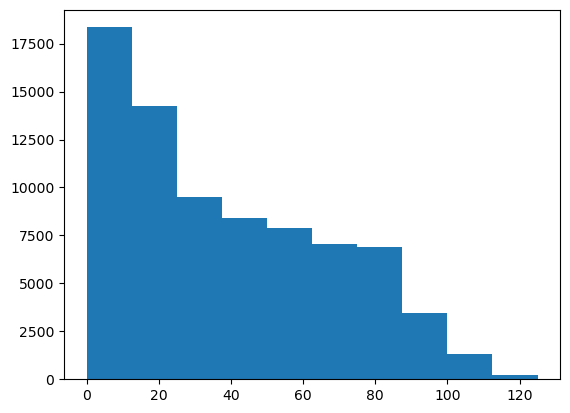

In [3]:
import matplotlib.pyplot as plt
h1=plt.hist(n_bins_L)